# Text classification challenge
### Building our own NLP

Can we create a model differentiating two bodies of text? 

#### Melville's Moby Dicka and Austen's Emma

We will try to classify these two bodies of text using Bag of Words and Term Frequency-Inverse Document Frequency approaches. After vectorization, the values will be pushed through different classification models for preliminary outcomes. Finally, a vectorization approach will be improved against a model to optimize outcomes.

In [1]:
from nltk.corpus import gutenberg, stopwords
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

In [2]:
# Quick test after noticing odd apostrophe escapement behavior
print(r"'" == r'\'')
test = r"Emma doing just what she liked;\nhighly esteeming Miss Taylor's judgment, but directed chiefly by\nher own."
re.sub("n", '*', test)

False


"Emma doi*g just what she liked;\\*highly esteemi*g Miss Taylor's judgme*t, but directed chiefly by\\*her ow*."

### Importing sklearn modules, pandas, numpy, visualization

We will be using a few different classifiers to see how they perform. We also need text extraction tools, metrics, and basics from NLTK.

### Checking Python and re '\\' behavior

There was some strange behavior with the escapement character '\' as it is a special case in both the language and the library. I ran this quick regular expression test at the beginning of the notebook to be sure it worked as intended.

In [3]:
moby = gutenberg.raw('melville-moby_dick.txt')
emma = gutenberg.raw('austen-emma.txt')

def cleanup(frame, source):
    # Removes the '\r\n' items across the text
    frame = re.sub('\r\n', ' ', frame)
    # The following two remove '--' which can have undesired effects
    frame = re.sub('--', '-', frame)
    frame = re.sub('--', '-', frame)
    # Removes '\n' across the text
    frame = re.sub(r"\\", '', frame)
    frame = re.sub('\n', ' ', frame)
    # The following two remove volume and chapter titles
    frame = re.sub(r'CHAPTER [A-Z]', '', frame)
    frame = re.sub(r'VOLUME [A-Z]', '', frame)
    # Tokenize by sentence with nltk
    frame_sents = sent_tokenize(frame)
    # Create empty list to populate with clean tokens
    frame_sents2 = []
    for sent in frame_sents:
        frame_sents2.append((re.sub('[^a-zA-Z\' -]+', '', sent).lower()))
    df = pd.DataFrame(frame_sents2, columns=['original_sentence'])
    df['source'] = source
    return df

moby_df = cleanup(moby, 'moby')
emma_df = cleanup(emma, 'emma')

def clean_title(moby_, emma_):
    moby_.loc[0]['original_sentence'] = 'etymology'
    emma_.loc[0]['original_sentence'] = 'Emma Woodhouse, handsome, clever, and rich, with a comfortable home and happy disposition, seemed to unite some of the best blessings of existence; and had lived nearly twenty-one years in the world with very little to distress or vex her.'
    return pd.concat([moby_, emma_], ignore_index=True)

df = clean_title(moby_df, emma_df)
# tfidf copy
df2 = df.copy()
# copy to improve
df3 = df.copy()
# Let's take a look across the dataframe
df.loc[np.random.randint(len(df), size=10)]

,original_sentence,source
3341,make fire-flies break the jinglers,moby
9734,the helm,moby
8412,then turning-the last link held fast in his le...,moby
3005,god bless ye men,moby
12851,this lesson she very much feared they would re...,emma
2273,upon the passage homewards they drop them ther...,moby
15648,not to my feelings,emma
3175,the prophecy was that i should be dismembered ...,moby
283,call me ishmael,moby
1742,young man said bildad sternly thou art skylark...,moby


In [4]:
# Using bag of words approach on the entire corpus assumes there are no words unique to one collection
# Here we set vectorizers and fit them
vec = CountVectorizer(ngram_range=(1,2), stop_words='english', max_features=100)
tvec = TfidfVectorizer(ngram_range=(1,2), stop_words='english', max_features=100)
bow = vec.fit_transform(df['original_sentence'])
tfidf = tvec.fit_transform(df['original_sentence'])

# This series of steps 
for name in vec.get_feature_names():
    df[name] = 0
    
for i, j in zip(*bow.nonzero()):
    df.loc[df.index[i], vec.get_feature_names()[j]] = bow[i, j]

X = df[vec.get_feature_names()]
y = df['source']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)#, stratify=y)

# These similar steps replicate the process for tfidf
for name in tvec.get_feature_names():
    df2[name] = 0

for i, j in zip(*tfidf.nonzero()):
    df2.loc[df2.index[i], tvec.get_feature_names()[j]] = tfidf[i, j]
    
X2 = df2[tvec.get_feature_names()]
y2 = df2['source']
    
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3)#, stratify=y2)

In [5]:
X_train.head()

,ahab,air,away,better,boat,body,came,captain,churchill,come,...,way,weston,whale,whales,white,woodhouse,world,ye,yes,young
600,0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,0,1,0,0
2235,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7924,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
11478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16451,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
X_train2.head()

,ahab,air,away,better,boat,body,came,captain,churchill,come,...,way,weston,whale,whales,white,woodhouse,world,ye,yes,young
5978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Above: Text cleaning and prep

With some regular expression tricks and looping, we now have a clean data set that can be represented in two forms: Bow and tf-idf. Both are created with vectorizers of 100 max features and ngram ranges of one to two.

#### Bag of Words

Counts the plain frequencies. Represented as integers in X_train.

#### Term Frequency - Inverse Document Frequency

Accounts for term frequencies per document frequency. Represented as float values in X_train2.

### Models

Now we can run the information through various models. The models will be strict classifiers, including logistic regression, a decision tree, and gradient boosting.

In [7]:
clf_log = LogisticRegression()
clf_log.fit(X_train, y_train)
clf_log.score(X_test, y_test)

C:\Users\clayp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7907828769764751

In [8]:
clf_tree = DecisionTreeClassifier()
clf_tree.fit(X_train, y_train)
clf_tree.score(X_test, y_test)

0.7743925954492865

In [9]:
clf_boost = GradientBoostingClassifier()
clf_boost.fit(X_train, y_train)
clf_boost.score(X_test, y_test)

0.7741997686077902

In [10]:
clf_log2 = LogisticRegression()
clf_log2.fit(X_train2, y_train2)
clf_log2.score(X_test2, y_test2)

C:\Users\clayp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7961820285383725

In [11]:
clf_tree2 = DecisionTreeClassifier()
clf_tree2.fit(X_train2, y_train2)
clf_tree2.score(X_test2, y_test2)

0.7774778249132279

In [12]:
clf_boost2 = GradientBoostingClassifier()
clf_boost2.fit(X_train2, y_train2)
clf_boost2.score(X_test2, y_test2)

0.781527188584651

### Preliminary results

The results are fairly predictable.

#### Logistic regression is competent, and fast.

It normally behaves this way - with binary classes it should shine.

#### The decision tree classifier is slower and not as accurate.

As a single tree as opposed to a forest, this is typically the case.

#### Gradient boosting performs better than the others, at the cost of computation time.

This is also very common with this classifier - it is, after all, an ensemble method.

#### Tf-idf outperforms BoW across the board.

It is a more advanced method containing more information about the entire corpus, so this is also expected.

# Improving results

### Tweaking tf-idf

The rest of the challenge will focus on changing some vectorizer parameters to try and improve a model by roughly five percent.

In [13]:
tvec2 = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                        min_df=2, # only use words that appear in at least x documents
                        stop_words='english', 
                        lowercase=True, # this shouldn't be necessary, but still
                        use_idf=True, # we definitely want to use inverse document frequencies in our weighting
                        norm='l2', # Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                        smooth_idf=True, # Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                        ngram_range=(1,3) # This creates unique n-grams x through y
                       )

final = tvec2.fit_transform(df3['original_sentence'])
    
X3 = finals
y3 = df3['source']
    
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3)

In [14]:
svd = TruncatedSVD(200)
lsa = make_pipeline(svd, Normalizer(norm='l2', copy=False))
train_lsa = lsa.fit_transform(X_train3)
test_lsa = lsa.fit_transform(X_test3)
print('Percent of variance captured: {}.'.format(svd.explained_variance_ratio_.sum() * 100))

Percent of variance captured: 23.414612792410523.


### The explained variance is much lower than the exercise

In the exercise, as much as 45 percent variance was captured. We are working with about half of that.

In [15]:
clf_log_final = LogisticRegression()
clf_log_final.fit(train_lsa, y_train3)
clf_log_final.score(test_lsa, y_test3)

C:\Users\clayp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6600462784419591

In [16]:
clf_tree_final = DecisionTreeClassifier()
clf_tree_final.fit(train_lsa, y_train3)
clf_tree_final.score(test_lsa, y_test3)

0.6849209409949865

In [17]:
clf_boost_final = GradientBoostingClassifier()
clf_boost_final.fit(train_lsa, y_train3)
print(clf_boost_final.score(test_lsa, y_test3))
print(confusion_matrix(y_test3, clf_boost_final.predict(test_lsa)))

0.8343617431546472
[[1736  525]
 [ 334 2591]]


# Observations

### Results do not scale across the board

The results following some vectorization tweaking have some unexpected results.

#### Only the ensemble method improved

The other models decreased in accuracy, drastically. 

#### With some changes, explained variance and scores were inversely proportional

Modifying some parameters increased the variance and reduced scores, such as min_df and n_gram ranges. I found this an interesting behavior that seemed unintuitive.

# Visualizing vectors

### Text is always high-dimensional

It is difficult to visualize what results when analyzing text like this. We can, however, use some decomposition techniques to try and compare the different vectors that stem from the text. It can show us how dissimilar the abstract vectors are from each other and how spread apart they are. 

### Below: Different tf-idf vectors using LSA visualized in two dimensions

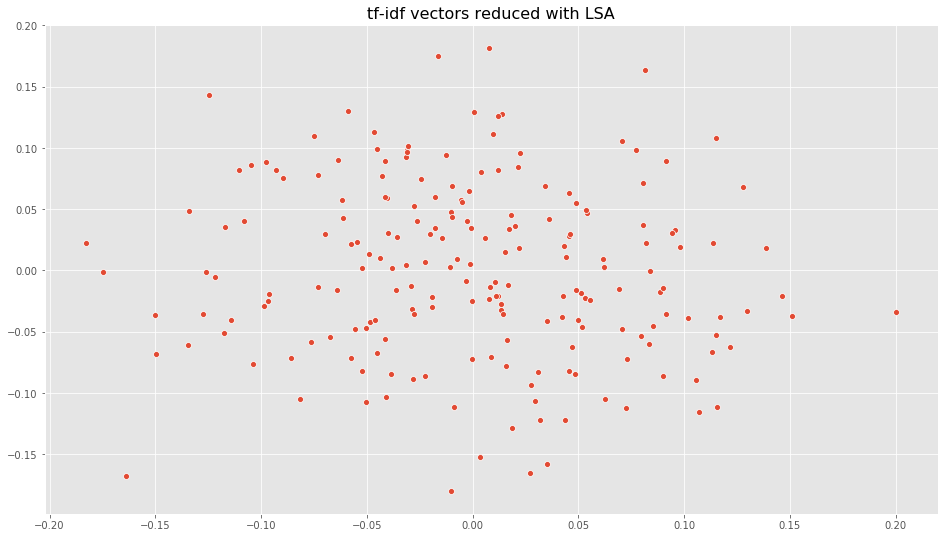

In [18]:
fig, ax = plt.subplots(figsize=(16,9))
ax.set_title('tf-idf vectors reduced with LSA', size=16)
sns.scatterplot(x=PCA(2).fit_transform(svd.components_)[:,0], y=PCA(2).fit_transform(svd.components_)[:,1])
plt.show()